# Imports

In [1]:
import sys, os

import s3fs
import xarray as xr

import progressbar

import warnings

import rasterio

from math import sqrt
from joblib import Parallel, delayed

import numpy as np

from matplotlib import pyplot as plt
import imageio

sys.path.append('../utilities')
import GrIS_committedSLR_calibration_utilities as utils
import mascons

import boto3

import pickle

import copy

import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Setup

In [2]:
start_year = 2007.
end_year = 2015.

grid_size = 50000.

grid_extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])

start_year_string = '{:4d}'.format(int(start_year))[2:]
end_year_string   = '{:4d}'.format(int(end_year)  )[2:]

# For plotting ...
import cartopy.crs as ccrs
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)


# Velocity observations

In [ ]:
_, _, vel_year1, _, _, vel_error_year1, vel_year1_transform, vel_year1_bounds = utils.read_vel_error_tifs(start_year)
_, _, vel_year2, _, _, vel_error_year2, vel_year2_transform, vel_year2_bounds = utils.read_vel_error_tifs(end_year)


In [ ]:
# Plot
fig, ax = plt.subplots(2,2,figsize=(12,20),dpi=300)
im0 = ax[0,0].imshow(vel_year1, cmap='magma', vmin=0, vmax=300)
im1 = ax[1,0].imshow(vel_error_year1, cmap='magma', vmin=0, vmax=25)
im2 = ax[0,1].imshow(vel_year2, cmap='magma', vmin=0, vmax=300)
im3 = ax[1,1].imshow(vel_error_year2, cmap='magma', vmin=0, vmax=25)
fig.colorbar(im0, ax=ax[0,0], orientation='horizontal', shrink=0.6)
fig.colorbar(im1, ax=ax[1,0], orientation='horizontal', shrink=0.6)
fig.colorbar(im2, ax=ax[0,1], orientation='horizontal', shrink=0.6)
fig.colorbar(im3, ax=ax[1,1], orientation='horizontal', shrink=0.6)

#fig.savefig('plots/vel_obs_{:4.0f}_{:4.0f}.png'.format(start_year, end_year), bbox_inches='tight')


## Grid the observations

In [ ]:
# Setup grid
x_centers = np.arange(grid_extent[0]+grid_size/2, grid_extent[1]-grid_size/2, grid_size)
y_centers = np.arange(grid_extent[2]+grid_size/2, grid_extent[3]-grid_size/2, grid_size)

vel_year1_obs_grid = utils.grid_vel_obs(vel_year1, vel_year1_transform, x_centers, y_centers, grid_size, grid_size)
vel_error_year1_obs_grid = utils.grid_vel_obs(vel_error_year1, vel_year1_transform, x_centers, y_centers, grid_size, grid_size)
vel_year2_obs_grid = utils.grid_vel_obs(vel_year2, vel_year2_transform, x_centers, y_centers, grid_size, grid_size)
vel_error_year2_obs_grid = utils.grid_vel_obs(vel_error_year2, vel_year2_transform, x_centers, y_centers, grid_size, grid_size)

dv_obs_grid = vel_year2_obs_grid - vel_year1_obs_grid
ev_obs_grid = np.sqrt(vel_error_year1_obs_grid**2 + vel_error_year2_obs_grid**2)

### Plot

In [ ]:
# Plot just the velocity differences
fig, ax = plt.subplots(2,1, figsize=(8,12), dpi=300, subplot_kw={'projection': polar_stereographic})
im0 = ax[0].imshow(dv_obs_grid, cmap='coolwarm', vmin=-25, vmax=25, extent=grid_extent, origin='lower')
im1 = ax[1].imshow(ev_obs_grid, cmap='magma',    vmin=0,   vmax=15, extent=grid_extent, origin='lower')
cb0 = fig.colorbar(im0, ax=ax[0], orientation='horizontal', pad=0.10, shrink=0.25)
cb1 = fig.colorbar(im1, ax=ax[1], orientation='horizontal', pad=0.10, shrink=0.25)

for i in range(len(ax)):
    ax[i].set_xticks([-500000, 0, 500000])
    ax[i].set_xticklabels(['-5000', '0', '5000'])
    ax[i].set_xlabel('easting (km)')
    ax[i].set_yticks([-3000000, -2000000, -1000000])
    ax[i].set_yticklabels(['-3000', '-2000', '-1000'])
    ax[i].set_ylabel('northing (km)')
    ax[i].coastlines()
    
cb0.ax.set_xlabel('m/yr')
cb1.ax.set_xlabel('m/yr')

fig.tight_layout(pad=0.01)
plt.savefig('plots/dv_obs_gridded_{:4.0f}_{:4.0f}.png'.format(start_year,end_year), bbox_inches='tight')


# Thickness change observations

In [ ]:
# Read dynamic dh from SERAC
dh_dyn_obs = utils.read_SERAC_obs('SERAC/SERACAnnualRates2021JanIGSPres.csv')

# select obs
dh_dyn_obs_selected = utils.select_dh_obs(dh_dyn_obs, startYear=start_year, endYear=end_year)
print('selected number of obs: {:8d}'.format(len(dh_dyn_obs_selected)))


## Grid the observations

In [ ]:
# Setup grid
x_centers = np.arange(grid_extent[0]+grid_size/2, grid_extent[1]-grid_size/2, grid_size)
y_centers = np.arange(grid_extent[2]+grid_size/2, grid_extent[3]-grid_size/2, grid_size)

# Setup another grid at 50 km for plotting purposes
grid_size_plot = 50000.
x_centers_plot = np.arange(grid_extent[0]+grid_size_plot/2, grid_extent[1]-grid_size_plot/2, grid_size_plot)
y_centers_plot = np.arange(grid_extent[2]+grid_size_plot/2, grid_extent[3]-grid_size_plot/2, grid_size_plot)


# Grid the observations
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    dh_obs_grid, dh_obs_sigma_grid = utils.grid_obs_dh(x_centers, y_centers, grid_size, grid_size, dh_dyn_obs_selected, \
                                                                                         startYear=start_year, endYear=end_year)
    dh_obs_grid_plot, dh_obs_sigma_grid_plot = utils.grid_obs_dh( \
                                    x_centers_plot, y_centers_plot, grid_size_plot, grid_size_plot, \
                                    dh_dyn_obs_selected, startYear=start_year, endYear=end_year)


In [ ]:
# Plot
fig, ax = plt.subplots(2,1, figsize=(8,12), dpi=300, subplot_kw={'projection': polar_stereographic})
im0 = ax[0].imshow(dh_obs_grid_plot, cmap='RdBu', vmin=-20, vmax=20, extent=grid_extent, origin='lower')
im1 = ax[1].imshow(dh_obs_sigma_grid_plot, cmap='Reds',    vmin=0,   vmax=2, extent=grid_extent, origin='lower')
cb0 = fig.colorbar(im0, ax=ax[0], orientation='horizontal', pad=0.10, shrink=0.25)
cb1 = fig.colorbar(im1, ax=ax[1], orientation='horizontal', pad=0.10, shrink=0.25)

for i in range(len(ax)):
    ax[i].set_xticks([-500000, 0, 500000])
    ax[i].set_xticklabels(['-5000', '0', '5000'])
    ax[i].set_xlabel('easting (km)')
    ax[i].set_yticks([-3000000, -2000000, -1000000])
    ax[i].set_yticklabels(['-3000', '-2000', '-1000'])
    ax[i].set_ylabel('northing (km)')
    ax[i].coastlines()
    
cb0.ax.set_xlabel('m')
cb1.ax.set_xlabel('m')

fig.tight_layout(pad=0.01)
plt.savefig('plots/dh_obs_gridded_{:4.0f}_{:4.0f}.png'.format(start_year,end_year), bbox_inches='tight')


# Mass change observations

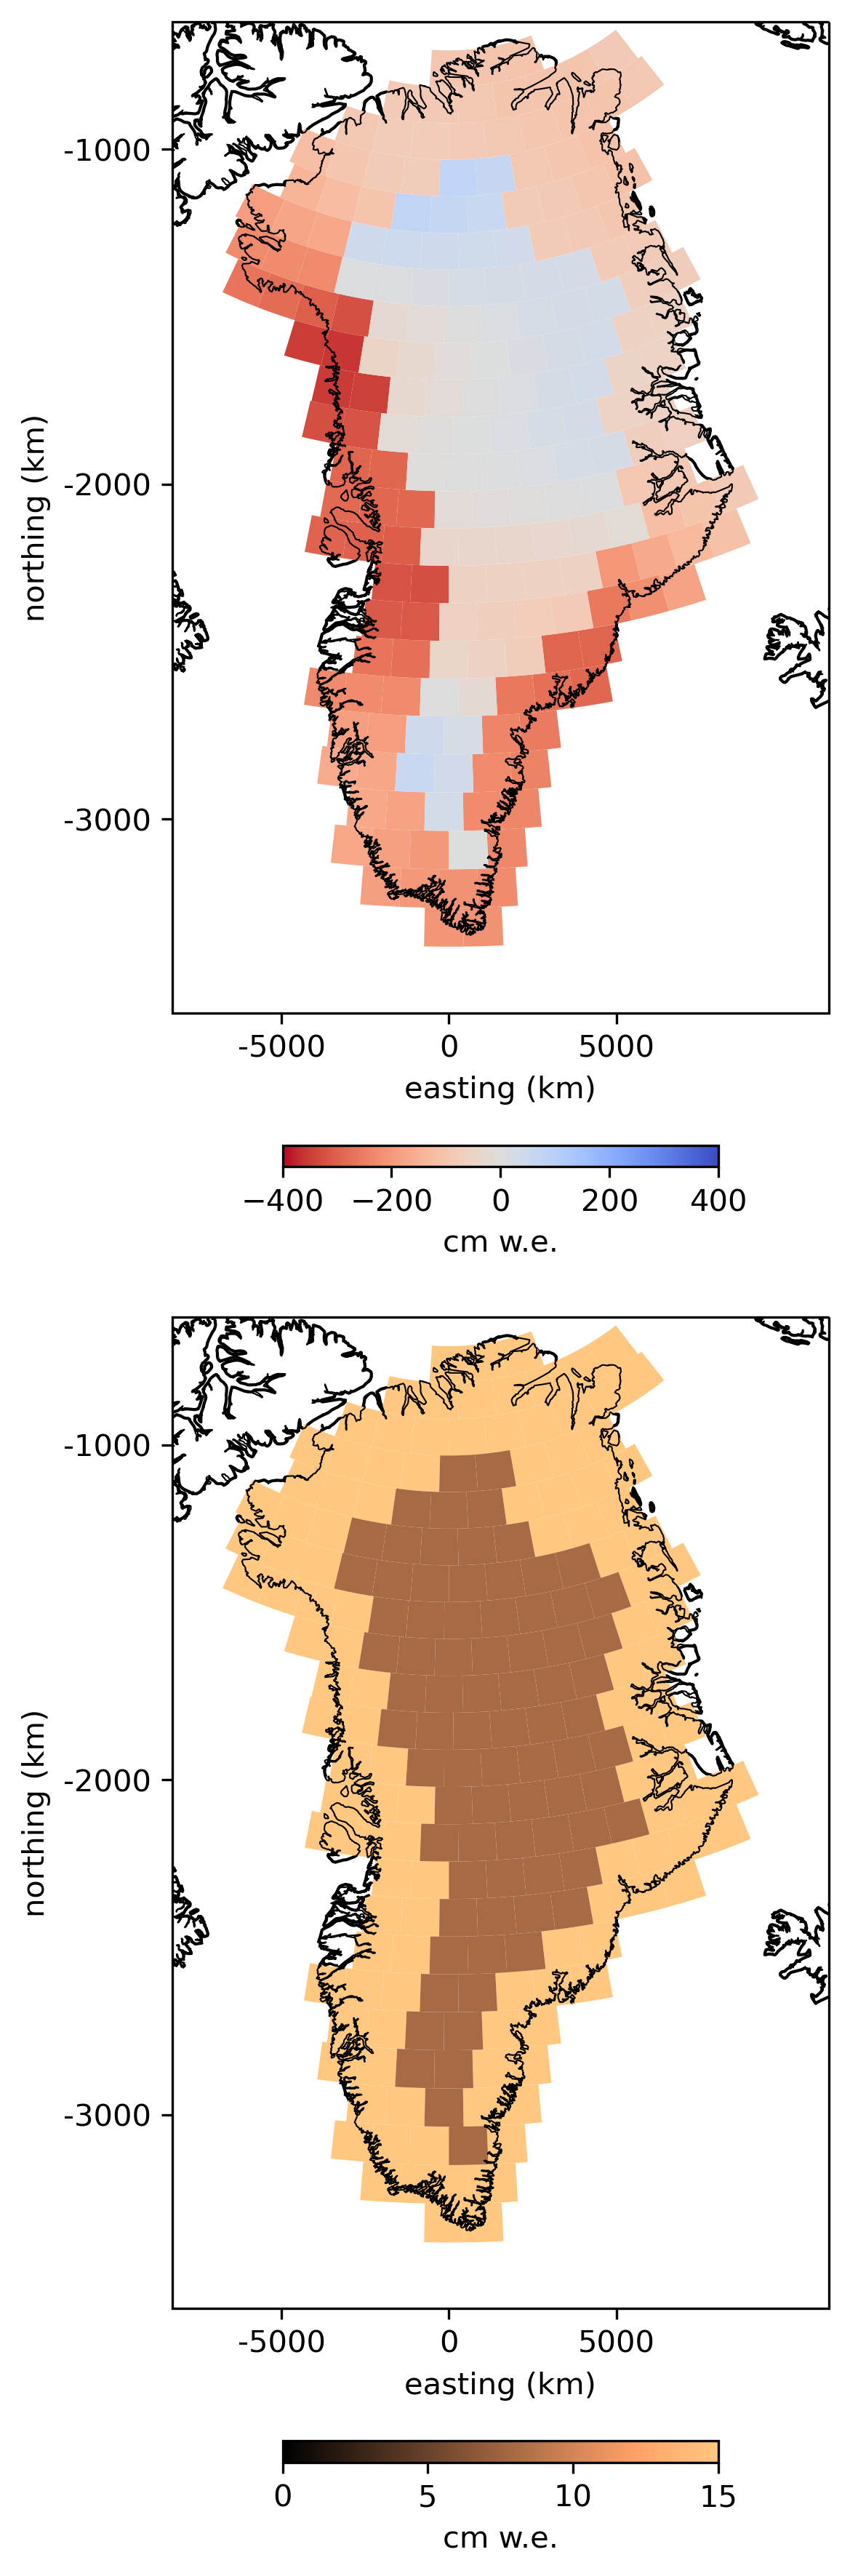

In [4]:
# dM residuals
# Compute mascon means
gsfc = utils.load_gscf_mascons()

start_date = '2007-01-01' # 'YYYY-MM-DD'
end_date = '2016-01-01' # 'YYYY-MM-DD'
gsfc_cmwe_delta = mascons.calc_mascon_delta_cmwe(gsfc, start_date, end_date)

# Select only GIS mascons
I_ = gsfc.locations == 1
gsfc_cmwe_delta = gsfc_cmwe_delta[I_]
lat_centers = gsfc.lat_centers[I_]
lon_centers = gsfc.lon_centers[I_]
min_lons = gsfc.min_lons[I_]
max_lons = gsfc.max_lons[I_]
min_lats = gsfc.min_lats[I_]
max_lats = gsfc.max_lats[I_]

vmin = -400
vmax = +400

# Plot
fig, ax = plt.subplots(2,1, figsize=(8,12), dpi=300, subplot_kw={'projection': polar_stereographic})

sc = utils.plot_GSFCmascons(lon_centers, lat_centers, gsfc_cmwe_delta, min_lons, max_lons, min_lats, max_lats, ax=ax[0], vmin=vmin, vmax=vmax)
cb0 = fig.colorbar(sc, ax=ax[0], orientation='horizontal', pad=0.10, shrink=0.25)
cb0.ax.set_xlabel('cm w.e.')

# Uncertainties
# Explanation from Bryant Loomis: "For that I get errors of 4 cm w.e. yr-1 for the low elevation region and 1 cm w.e. yr-1 for the high elevation region (standard deviations are 7.0 and 4.8)."
# low = mascons 0-119; high = mascons 120-198
idx_lo = gsfc.labels[I_] <= 119
idx_hi = gsfc.labels[I_] >= 120
gsfc_cmwe_delta_sigma = copy.deepcopy(gsfc_cmwe_delta)
gsfc_cmwe_delta_sigma[idx_lo] = 4
gsfc_cmwe_delta_sigma[idx_hi] = 1

gsfc_cmwe_delta_sigma = 8*gsfc_cmwe_delta_sigma

sc_err = utils.plot_GSFCmascons(lon_centers, lat_centers, gsfc_cmwe_delta_sigma, min_lons, max_lons, min_lats, max_lats, ax=ax[1], vmin=0, vmax=15, cmap='copper')
cb1 = fig.colorbar(sc_err, ax=ax[1], orientation='horizontal', pad=0.10, shrink=0.25)
cb1.ax.set_xlabel('cm w.e.')

# Save figure
for i in range(len(ax)):
    ax[i].set_xticks([-500000, 0, 500000])
    ax[i].set_xticklabels(['-5000', '0', '5000'])
    ax[i].set_xlabel('easting (km)')
    ax[i].set_yticks([-3000000, -2000000, -1000000])
    ax[i].set_yticklabels(['-3000', '-2000', '-1000'])
    ax[i].set_ylabel('northing (km)')
    ax[i].coastlines()
    
cb0.ax.set_xlabel('cm w.e.')
cb1.ax.set_xlabel('cm w.e.')

fig.tight_layout(pad=0.01)
plt.savefig('plots/dM_obs_2007_2015.png', bbox_inches='tight')


CW -294.8
NE -160.5
NO -178.4
NW -585.2
SE -687.0
SW -477.2
CW  38.6
NE  121.9
NO  82.3
NW  78.2
SE  106.1
SW  79.3


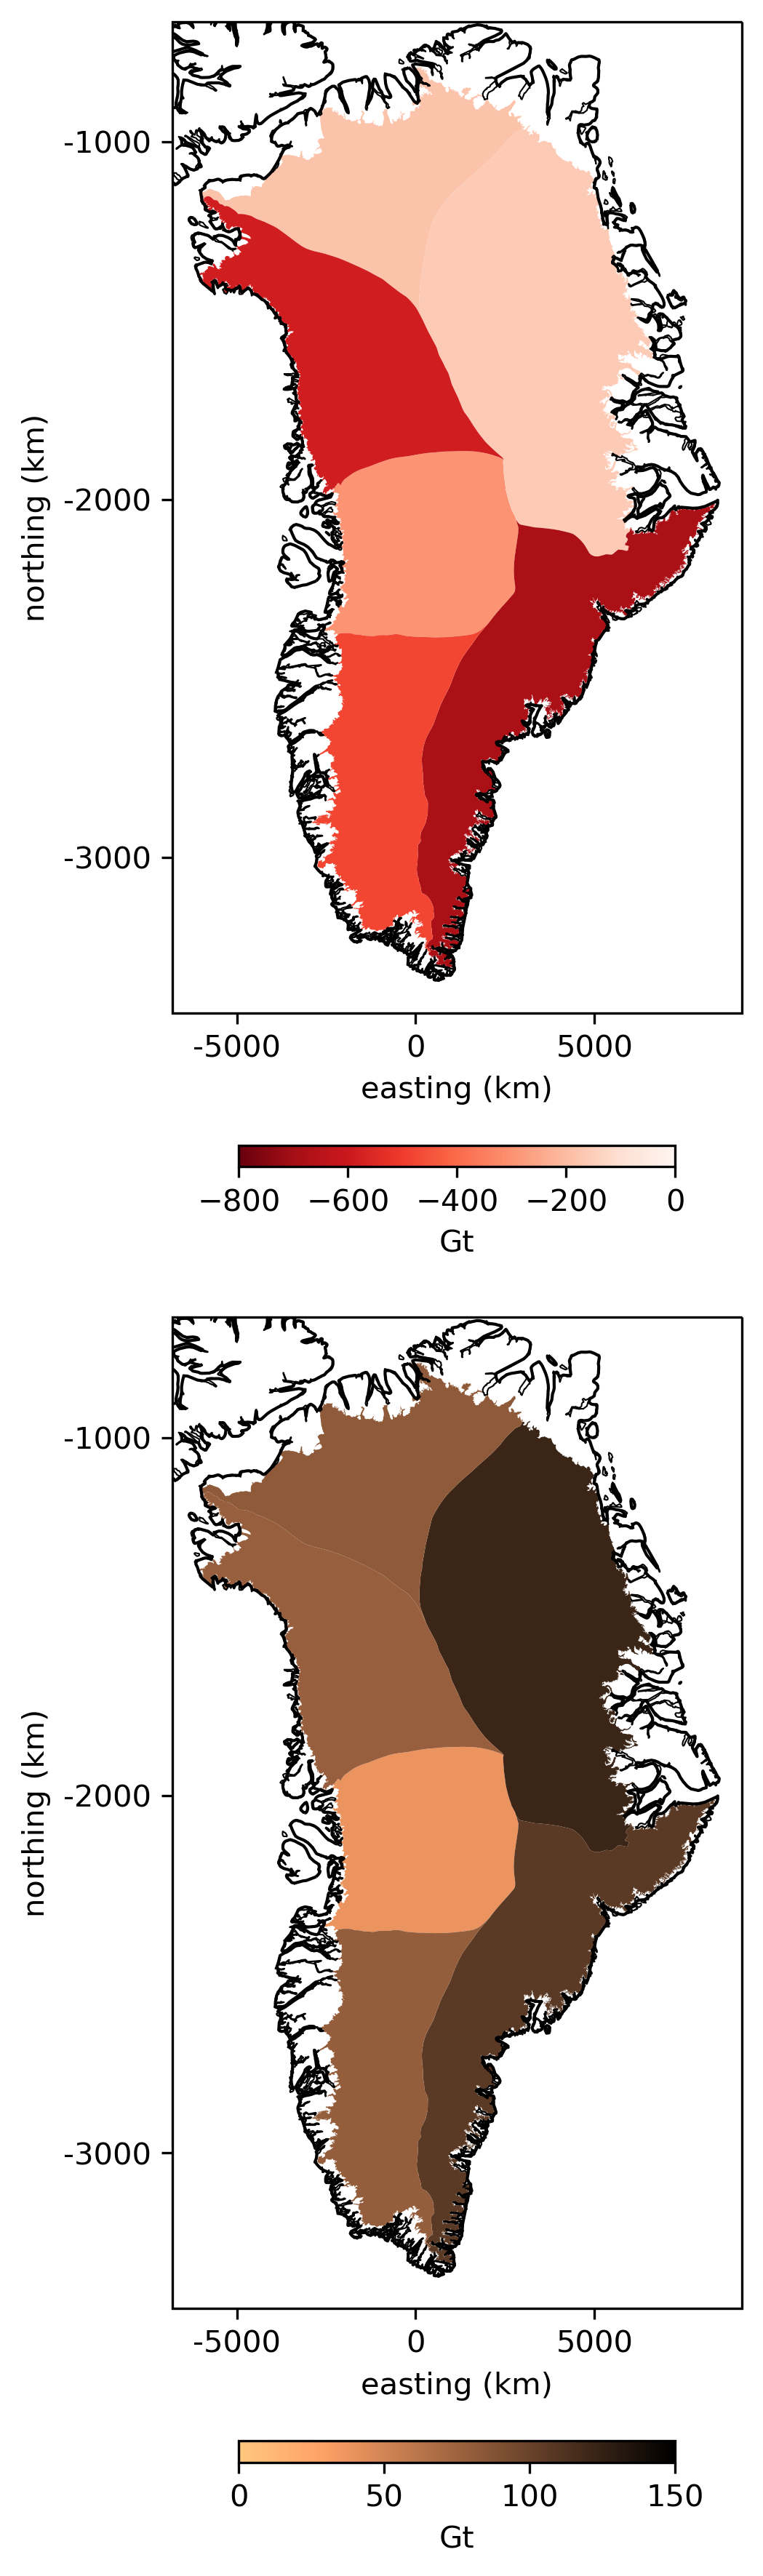

In [21]:
import importlib
importlib.reload(utils)

# Plot
fig, ax = plt.subplots(2,1, figsize=(8,12), dpi=300, subplot_kw={'projection': polar_stereographic})

gsfc_Gt_delta = (gsfc_cmwe_delta/100.) * (gsfc.areas[I_]*1000.*1000.) * 1000. * 1e-12

sc, gsfc_cmwe_basin_rignot = utils.plot_GSFCmascons_by_basin(lon_centers, lat_centers, gsfc_Gt_delta, gsfc.labels[I_], ax=ax[0], vmin=-800, vmax=0, verbose=True)
cb0 = fig.colorbar(sc, ax=ax[0], orientation='horizontal', pad=0.10, shrink=0.25)
cb0.ax.set_xlabel('cm w.e.')

gsfc_Gt_delta_sigma = (gsfc_cmwe_delta_sigma/100.) * (gsfc.areas[I_]*1000.*1000.) * 1000. * 1e-12

sc_err, gsfc_cmwe_basin_rignot = utils.plot_GSFCmascons_by_basin(lon_centers, lat_centers, gsfc_Gt_delta_sigma, gsfc.labels[I_], ax=ax[1], \
                                         vmin=0, vmax=150, cmap='copper_r', verbose=True)
cb1 = fig.colorbar(sc_err, ax=ax[1], orientation='horizontal', pad=0.10, shrink=0.25)
cb1.ax.set_xlabel('cm w.e.')

# Save figure
for i in range(len(ax)):
    ax[i].set_xticks([-500000, 0, 500000])
    ax[i].set_xticklabels(['-5000', '0', '5000'])
    ax[i].set_xlabel('easting (km)')
    ax[i].set_yticks([-3000000, -2000000, -1000000])
    ax[i].set_yticklabels(['-3000', '-2000', '-1000'])
    ax[i].set_ylabel('northing (km)')
    ax[i].coastlines()
    
cb0.ax.set_xlabel('Gt')
cb1.ax.set_xlabel('Gt')

fig.tight_layout(pad=0.01)
plt.savefig('plots/dM_obs_gridded_2007_2015.png', bbox_inches='tight')


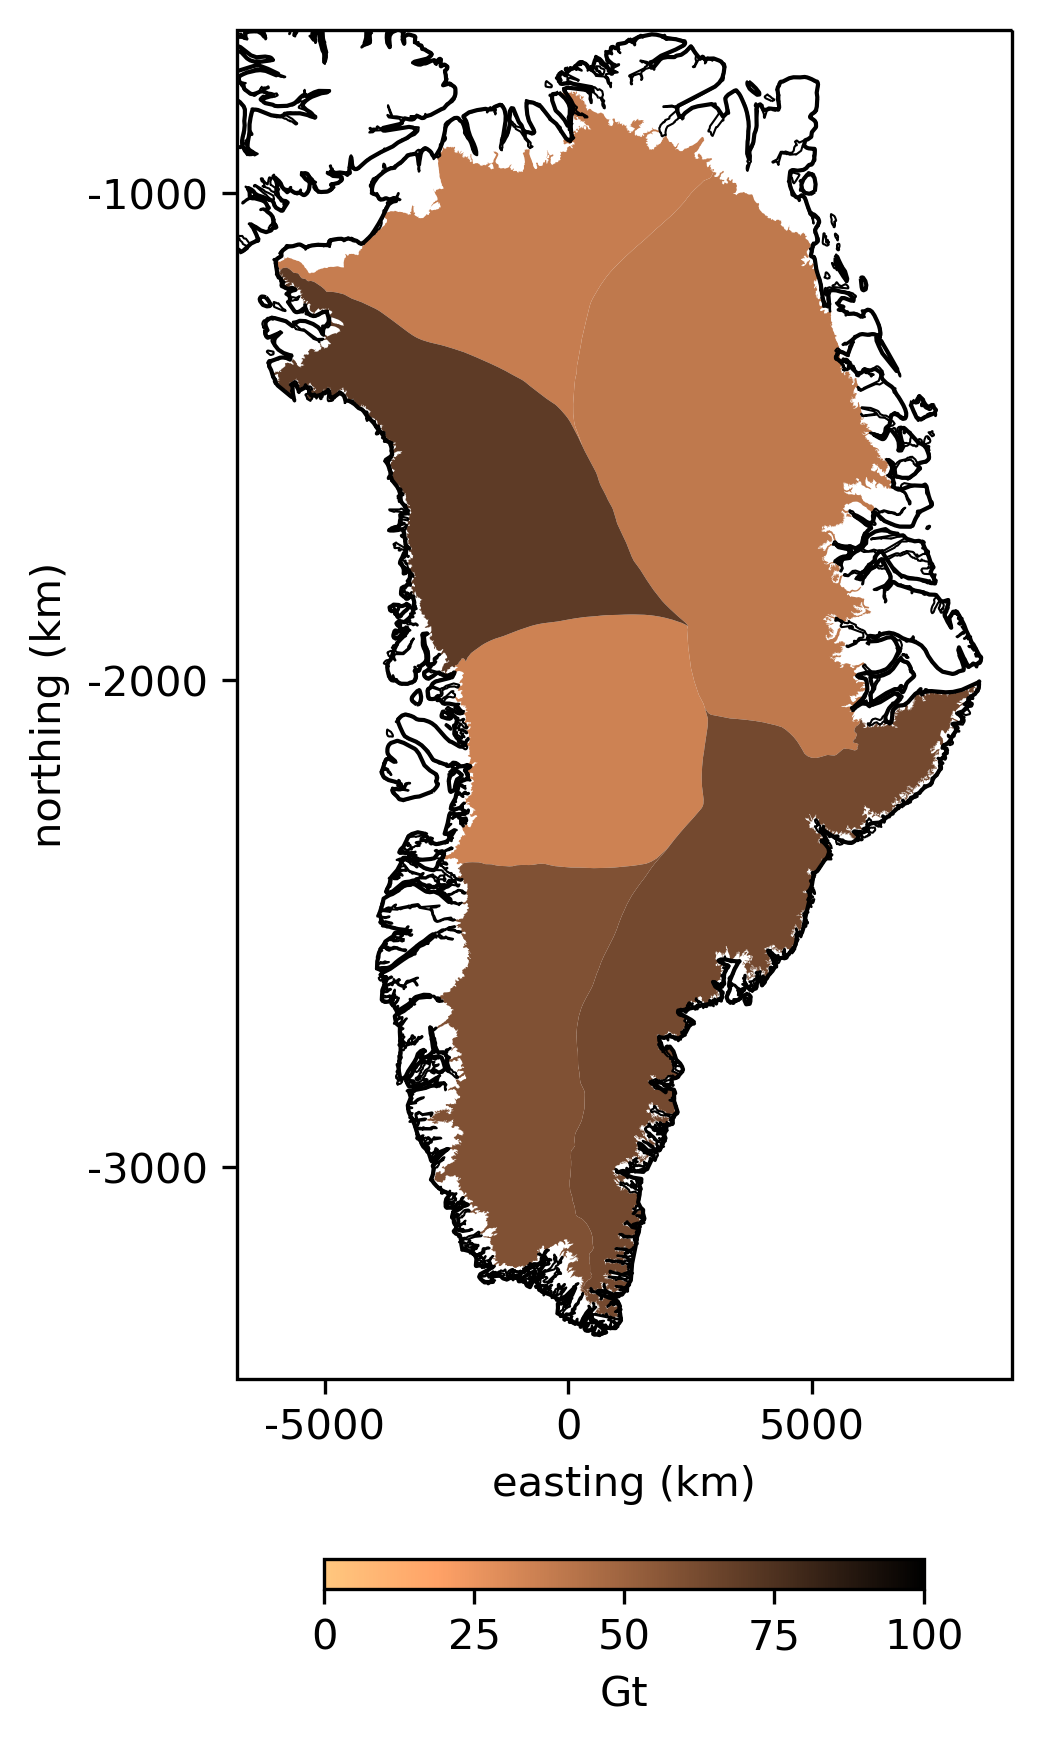

In [30]:
with open('../utilities/GRACE_basin_uncertainties_Loomis2021.txt', 'r') as f:
    gsfc_basin_uncertainties_loomis2021_lines = f.read().splitlines()
    
gsfc_basin_uncertainties_loomis2021 = {line.split()[0]: float(line.split()[1]) for line in gsfc_basin_uncertainties_loomis2021_lines}

fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=300, subplot_kw={'projection': polar_stereographic})
sc_err = utils.plot_values_by_basin(gsfc_basin_uncertainties_loomis2021, ax, 'copper_r', 0, 100)

cb = fig.colorbar(sc_err, ax=ax, orientation='horizontal', pad=0.10, shrink=0.25)
cb.ax.set_xlabel('cm w.e.')

# Save figure
ax.set_xticks([-500000, 0, 500000])
ax.set_xticklabels(['-5000', '0', '5000'])
ax.set_xlabel('easting (km)')
ax.set_yticks([-3000000, -2000000, -1000000])
ax.set_yticklabels(['-3000', '-2000', '-1000'])
ax.set_ylabel('northing (km)')
ax.coastlines()

cb.ax.set_xlabel('Gt')

fig.tight_layout(pad=0.01)
plt.savefig('plots/dM_obs_uncertainty_loomis2021_gridded_2007_2015.png', bbox_inches='tight')
